In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from definitions import ROOT_DIR
import seaborn as sns
from matplotlib.colors import to_rgba
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'sans-serif',
             'sans-serif':['Arial'],
             'size':12})
rc('pdf', fonttype=42)
rc('ps', fonttype=42)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [29]:
#Format series formulas to publication standard
def pretty_ion_formulas(data, colname):
       
    new_series = data[colname].copy()
    new_series = new_series.str.replace(r"[M]-", "", regex=False)
    new_series = new_series.str.replace(r"[M]+", "", regex=False)
    new_series = new_series.str.replace("([0-9])","$_\\1$", regex=True)
    new_series = [f"[M{s}]" if s != "Other" else s for s in new_series]
        
    newdata = data.copy() 
    newdata[colname] = new_series
    
    # Add ion charge in superscript accordint to the polarity - $ LaTeX notation
    newdata.loc[newdata.Polarity == "positive", colname].apply(lambda s: f"{s}$^+$'")
    newdata.loc[newdata.Polarity == "positive", colname].apply(lambda s: f"{s}$^-$'")
    
    for i, r in newdata.iterrows():
        polarity = r.Polarity
        s = r[colname]
        if s!="Other":
            if polarity == 'positive':
                newdata.loc[i, colname] = f"{s}$^+$"
            else:
                newdata.loc[i, colname] = f"{s}$^-$"
    return newdata

In [2]:
p_root_dir = Path(ROOT_DIR)
p_data = p_root_dir / "data"

# Predictions
p_predictions = p_data / "Interlab_data_19Apr2023.csv"
source = p_predictions.stem

In [3]:
# Load predictions and format neutral loss column
df = pd.read_csv(p_predictions)
df.neutral_loss.fillna('', inplace=True)

# Only consider data of detected ions
threshold = 0.8
df['detectability'] = df.pred_val >= threshold
data = df[df.detectability]

In [4]:
# Sum intensities of detected ions per metabolite in each sample
data['sum_intensity_per_metabolite'] = data.groupby(["Sample name", "name_short"])["spot_intensity_bgr_corrected"].transform('sum')

# Calculate the fractions of detected ion intensities per metabolite in each sample
data['fraction_per_ion'] = data.spot_intensity_bgr_corrected / data.sum_intensity_per_metabolite

<ipython-input-4-52d6c918a8ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sum_intensity_per_metabolite'] = data.groupby(["Sample name", "name_short"])["spot_intensity_bgr_corrected"].transform('sum')
<ipython-input-4-52d6c918a8ad>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['fraction_per_ion'] = data.spot_intensity_bgr_corrected / data.sum_intensity_per_metabolite


### Example signal dilution for one compound in one data set

In [97]:
p_out = p_root_dir / "plots" / "signal_dilution" / "metabolite_examples"
p_out.mkdir(exist_ok=True, parents=True)

In [98]:
example_data = data[(data["Participant lab"] == "EMBL")&
                    ((data.Polarity == "positive")&(data.name_short.isin(['Cholesterol', 'Retinoic acid'])) |
                    (data.Polarity == "negative")&(data.name_short=='Adenosine triphosphate'))]

# Add new column
example_data['ion_type'] = example_data.adduct + example_data.neutral_loss

# Edit ion formulas
example_data = pretty_ion_formulas(example_data, "ion_type")

<ipython-input-98-e79015f38bca>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_data['ion_type'] = example_data.adduct + example_data.neutral_loss


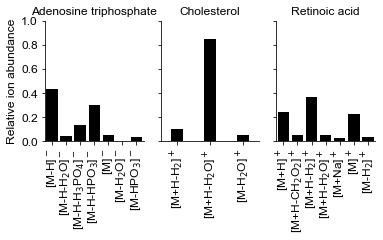

In [101]:
title = "metabolite_examples"

def change_width(ax, new_value):
    for patch in ax.patches:
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

fig, ax = plt.subplots(1, 3, figsize=(5.5, 3.5), sharey=True)
for i, mol in enumerate(example_data.name_short.unique()):
    sns.barplot(
        ax=ax[i],
        data=example_data[example_data.name_short==mol],
        x="ion_type", y="fraction_per_ion",
        color='k')
    ax[i].set(xlabel="", ylabel="")
    ax[i].set_title(mol, fontsize=12)
    ax[i].set_xticklabels(labels=ax[i].get_xticklabels(), rotation=90)
    ax[i].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

ax[0].set(xlabel="", ylabel="Relative ion abundance")
change_width(ax[1], 2.5/7)
sns.despine()
fig.tight_layout()

fig.savefig(p_out / f"{title}.png")
fig.savefig(p_out / f"{title}.pdf", transparent=True)